# Analyzing Player Interactions and Importance Using Graph Attention Networks

This notebook explores the use of Graph Attention Networks (GATs) to analyze player interactions and determine their importance in a game setting. The data used includes player positions, movements, and interactions during a match.

### Introduction

Graph Attention Networks (GATs) are a type of neural network architecture that can model relationships in graph-structured data. In this context, we use GATs to analyze how players interact on the field and identify key players based on their interactions.

### Loading packages

We begin by loading the necessary libraries for this notebook.

In [1]:
import bz2
import json
import pandas as pd
import numpy as np
import os
import pickle
import convert_tracking as ct
import plot_functions as pf
import create_graph as cg
import GNNs.model_training as mt
import GNNs.convert_data as cd
import GNNs.GAT as GAT
import scale_graph as sg
import gc
import tqdm
import visualisation

os.chdir('Data')
game_id = 13335
filepath = str(game_id) + '.jsonl.bz2'

C:\Apps\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Apps\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Apps\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Loading data

Next, we load our tracking data.

- **Balls Data**: Contains information about the ball's position and movement.
- **Events Data**: Includes various events that occur during the game, such as passes and shots.
- **Players Data**: Provides details about each player's position, team, and visibility on the field.

In [2]:
home_team_id,away_team_id,home_team_name,away_team_name,home_team_start_left,rosters_for_game_home,rosters_for_game_away,roster_game_home_name_dict,roster_game_home_team_name_dict,roster_game_home_pos_dict,roster_game_away_name_dict,roster_game_away_team_name_dict,roster_game_away_pos_dict,pitch_x_adjustment,pitch_y_adjustment = ct.get_metadata(game_id)
balls_df = pd.read_csv('game_dataframes/13335/13335_balls_df.csv')
events_df = pd.read_csv('game_dataframes/13335/13335_events_df.csv')
players_df = pd.read_csv('game_dataframes/13335/13335_players_df.csv')
balls_df = ct.calculate_ball_velocities(balls_df)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

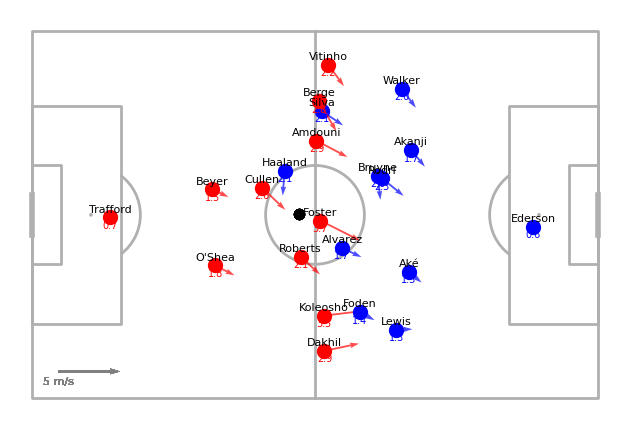

In [3]:
pf.plot_players_on_pitch(players_df[players_df['frameNum'] == 4620],balls_df[balls_df['frameNum']==4620], annotate=True, show_velocities=True)

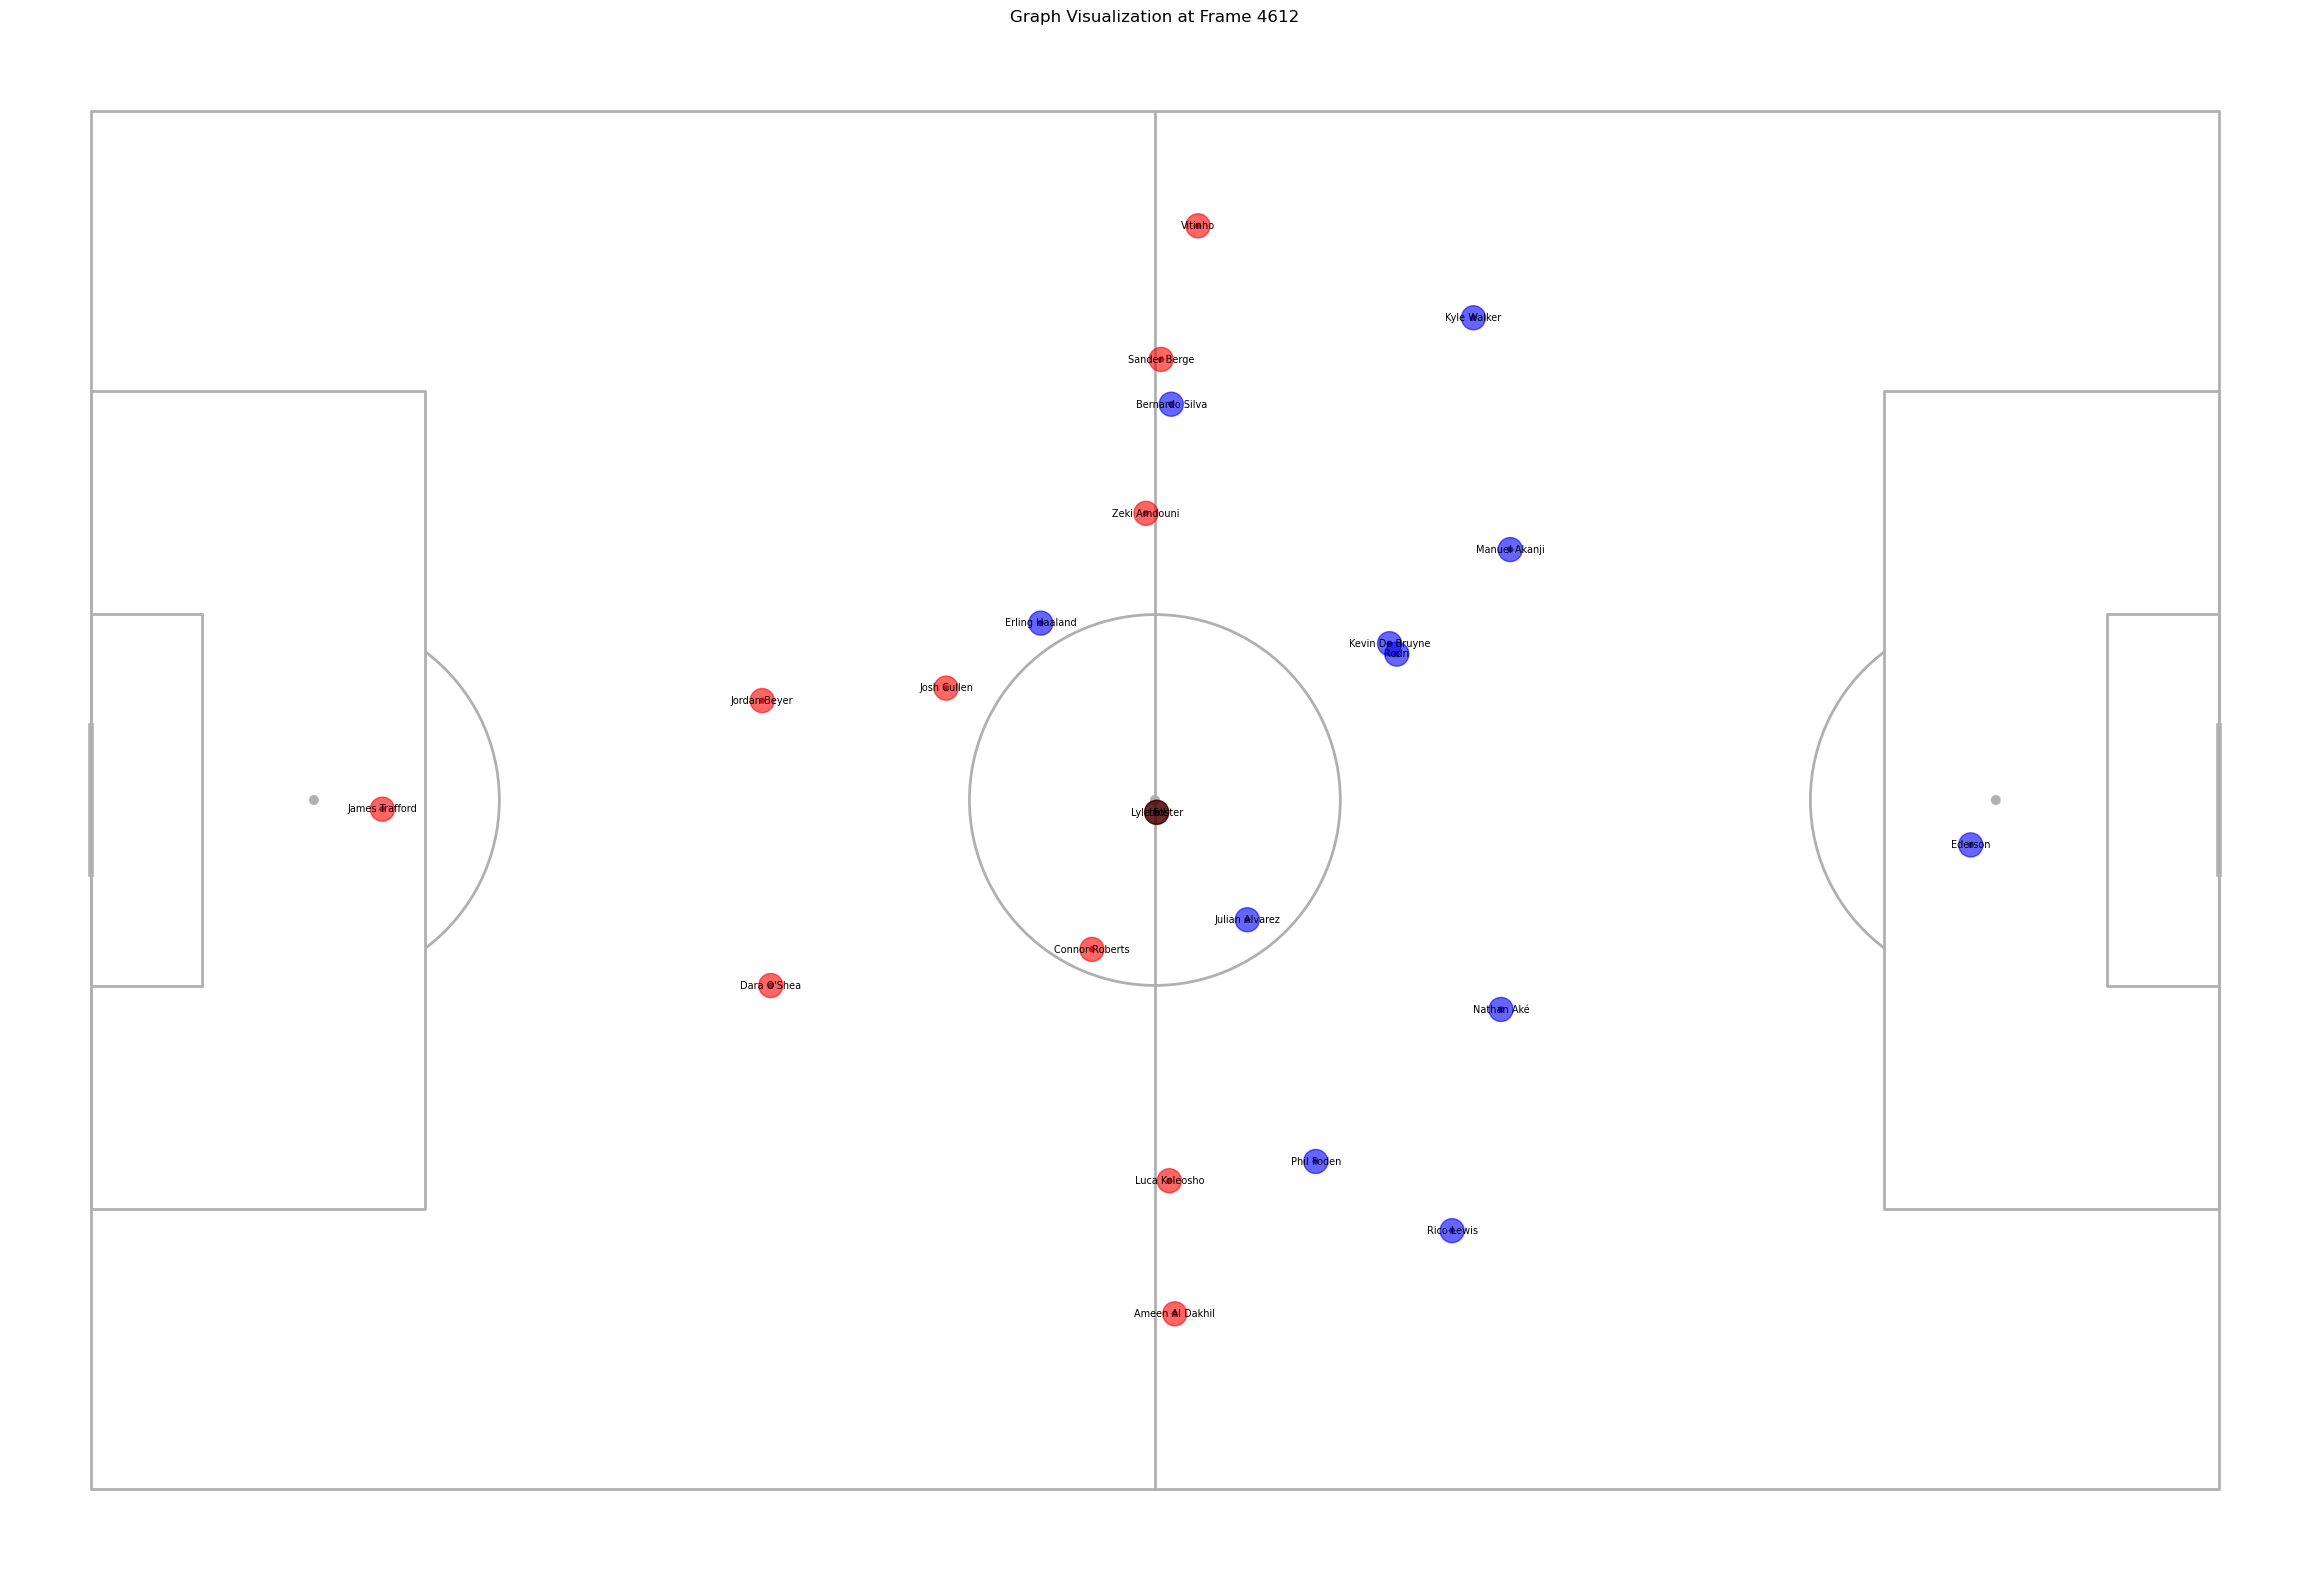

Number of nodes: 23
Number of edges: 506


In [4]:
G = cg.create_normalized_graph_directed(players_df, balls_df, events_df, 4612, home_team_name)
pf.visualize_graph_on_pitch_AT(G, 4612)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

### Convert data to graphs

Loop over multiple games and create a dataset of graphs from event frames for input to a GNN model

In [5]:
graphs = []
frame_numbers = []
game_ids = []

for game_id in tqdm.tqdm(os.listdir('game_dataframes')[:1]):
    try:
        game_id = int(game_id)
        home_team_id,away_team_id,home_team_name,away_team_name,home_team_start_left,rosters_for_game_home,rosters_for_game_away,roster_game_home_name_dict,roster_game_home_team_name_dict,roster_game_home_pos_dict,roster_game_away_name_dict,roster_game_away_team_name_dict,roster_game_away_pos_dict,pitch_x_adjustment,pitch_y_adjustment = ct.get_metadata(game_id)
        balls_df = pd.read_csv('game_dataframes/'+str(game_id)+'/'+str(game_id)+'_balls_df.csv')
        events_df = pd.read_csv('game_dataframes/'+str(game_id)+'/'+str(game_id)+'_events_df.csv')
        players_df = pd.read_csv('game_dataframes/'+str(game_id)+'/'+str(game_id)+'_players_df.csv')
        balls_df = ct.calculate_ball_velocities(balls_df)

        event_frames = events_df['frameNum'].values
        for frameNum in event_frames:
            G = cg.create_normalized_graph_directed(players_df, balls_df, events_df, frameNum, home_team_name)
            if G != None:
                graphs.append(G)
                frame_numbers.append(frameNum)
                game_ids.append(game_id)
        del players_df
        del balls_df
        del events_df
        gc.collect()
    except:
        continue
graph_scaler = sg.GraphFeatureScaler()
graph_scaler.fit(graphs)
scaled_graphs = [graph_scaler.transform_graph(G) for G in graphs]
dataset = cd.prepare_dataset_reception(scaled_graphs)

100%|██████████| 1/1 [03:19<00:00, 199.40s/it]


### Run the GNN

Train the GNN model and look at model predictions

In [6]:
model_reception_AT,train_loader_AT,test_loader_AT = mt.train_reception_prediction_AT_model(scaled_graphs, num_epochs=10, batch_size=16, hidden_channels=32, edge_hidden_channels=16, lr=0.001)

In [7]:
model_reception,train_loader,test_loader = mt.train_reception_prediction_model(scaled_graphs, num_epochs=40, batch_size=64, hidden_channels=32, lr=0.001)

In [10]:
results_df, attention_analysis = visualisation.predict_reception_probabilities(model_reception_AT,scaled_graphs[40],head_indexes=[0,1])